This notebook is part of [**MicroGP v4!2.0**](https://github.com/microgp/microgp4)
Copyright 2023 Giovanni Squillero and Alberto Tonda
SPDX-License-Identifier: Apache-2.0

In [1]:
import microgp4 as ugp

/var/folders/31/dkl97hks2c14b663vl55pt440000gn/T/ipykernel_25352/70525116.py:1: RuntimeWarning: 
  Paranoia checks are always enabled in notebooks: performances can be significantly impaired
  import microgp4 as ugp


In [2]:
register = ugp.f.choice_parameter([f"x{n}" for n in range(4)])
int8 = ugp.f.integer_parameter(0, 2**8)
int16 = ugp.f.integer_parameter(0, 2**16)

In [3]:
operations_rr = ugp.f.choice_parameter(["add", "adc", "sub", "sbc", "mul"])
operations_ri = ugp.f.choice_parameter(["add", "sub"])
op_rr = ugp.f.macro("{op} {r1}, {r2}, {r3}", op=operations_rr, r1=register, r2=register, r3=register)
op_ri = ugp.f.macro("{op} {r1}, {r2}, #{imm:#x}", op=operations_ri, r1=register, r2=register, imm=int8)

In [4]:
conditions = ugp.f.choice_parameter(
    ["eq", "ne", "cs", "hs", "cc", "lo", "mi", "pl", "vs", "vc", "hi", "ls", "ge", "lt", "gt", "le", "al"]
)
branch = ugp.f.macro("b{cond} {label}", cond=conditions, label=ugp.f.local_reference(backward=False, loop=False))

In [5]:
prologue = ugp.f.macro(
    r"""; prologue
.section	__TEXT,__text,regular,pure_instructions
.globl	_one_max    ; function one_max
.p2align	2
_one_max:
.cfi_startproc"""
)

epilogue = ugp.f.macro(
    r"""; epilogue
ret
.cfi_endproc"""
)

init = ugp.f.macro(
    r"""; initialization
mov x0, #{v0:#x}
mov x1, #{v1:#x}
mov x2, #{v2:#x}
mov x3, #{v3:#x}""",
    v0=int16,
    v1=int16,
    v2=int16,
    v3=int16,
)

In [6]:
core = ugp.f.bunch([op_rr, op_ri, op_rr, op_ri, branch], size=(10, 20+1))
program = ugp.f.sequence([prologue, init, core, epilogue])

In [7]:
population = ugp.classes.Population(top_frame=program, fitness_function=None)
population.add_random_individual()

In [8]:
code = population.dump_individual(0, {"$dump_node_info": 1})

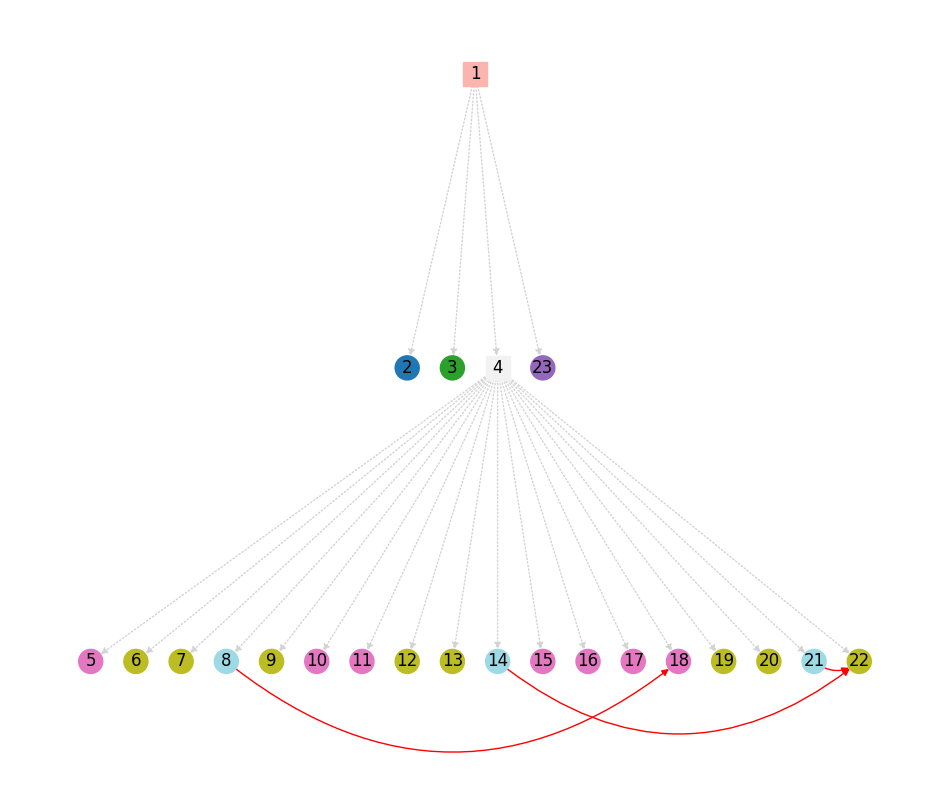

In [9]:
population.individuals[0].draw()

In [10]:
str(population.individuals[0])

'Individual with 2 frames and 21 macros (67 parameters total, 3 structural)'

In [11]:
population.individuals[0].save_figure('z.pdf', (20, 20), bbox_inches='tight')